# Heart Disease Patients Classification
###### METIS Data Science and Machine Learning Bootcamp 2022 by Krystian Krystkowiak
###### project/month(4/7) focus: CLASSIFICATION

ABSTRACT
- To predict heart disease patients, implemented and fine-tuned various classification models (KNN, Logistic Regression, Random Forest, XGBoost, Naive Bayes), utilizing techniques such as regularization, ensembling, and addressing class imbalance. Achieved Recall score of 86% with XGBoost.

DATA IMPORT/CLEANING/PREPROCESSING

In [2]:
# processing imports
import pandas as pd
import numpy as np
from collections import Counter

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.naive_bayes import BernoulliNB
import statsmodels.api as sm

# Set style for plots
plt.style.use('fivethirtyeight')

# Show plots inline
%matplotlib inline


/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df = pd.read_csv('heart_2020_cleaned.csv')  
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [5]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [6]:
df.isnull().values.any()

False

In [8]:
df = pd.get_dummies(df, columns=['AgeCategory','Race','Diabetic', 'GenHealth'], drop_first=True)

In [9]:
df =  df[df.columns].replace({'Yes':1, 'No':0, 'Female':1,'Male':0 })

In [10]:
df.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,...,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,0.524727,0.775362,...,0.085824,0.034172,0.766779,0.021204,0.127588,0.008002,0.108435,0.291215,0.035301,0.356034
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,0.417344,...,0.280104,0.181671,0.422883,0.144065,0.333631,0.089095,0.310930,0.454323,0.184539,0.478826
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.nunique()

HeartDisease                           2
BMI                                 3604
Smoking                                2
AlcoholDrinking                        2
Stroke                                 2
PhysicalHealth                        31
MentalHealth                          31
DiffWalking                            2
Sex                                    2
PhysicalActivity                       2
SleepTime                             24
Asthma                                 2
KidneyDisease                          2
SkinCancer                             2
AgeCategory_25-29                      2
AgeCategory_30-34                      2
AgeCategory_35-39                      2
AgeCategory_40-44                      2
AgeCategory_45-49                      2
AgeCategory_50-54                      2
AgeCategory_55-59                      2
AgeCategory_60-64                      2
AgeCategory_65-69                      2
AgeCategory_70-74                      2
AgeCategory_75-7

EDA

In [178]:
df.HeartDisease.mean()
#strong class imbalance - to be adressed later

0.08559545959130067

Unbalanced distribution of people with heart disease in dataset.


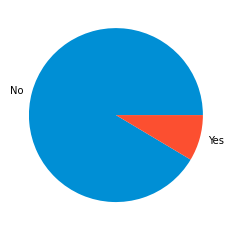

In [176]:
print('Unbalanced distribution of people with heart disease in dataset.')
plt.pie(df['HeartDisease'].value_counts(), labels = ['No', 'Yes'])
plt.show()

In [177]:
#considered feature engineering (combining smoking and drinking with physical activity or age did not bring visible results, proceeding to modelling

PREPARATION FOR MODELING

In [179]:
#Select Features
X = df.drop(columns =['HeartDisease'], axis = 1)

#Select Target 
y = df['HeartDisease']

# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, shuffle = True, test_size = .15, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, shuffle = True, test_size = .15, random_state = 42)


print('Shape of training feature:', X_train.shape)
print('Shape of validation feature:', X_val.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of validation label:', y_val.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (231051, 37)
Shape of validation feature: (40774, 37)
Shape of testing feature: (47970, 37)
Shape of training label: (231051,)
Shape of validation label: (40774,)
Shape of training label: (47970,)


In [180]:
#to address class imbalance and since I have a lot of data, I undersample

RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = 0.5, random_state=42)

X_tr_us, y_tr_us = RUS.fit_resample(X_train, y_train)

In [181]:
print('Shape of training us feature:', X_tr_us.shape)
print('Shape of training us label:', y_tr_us.shape)

Shape of training us feature: (59127, 37)
Shape of training us label: (59127,)


In [182]:
#scaling
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)
X_tr_us_scaled = std_scale.fit_transform(X_tr_us) #as I noticed that is training set that brought best results in most of the models.

In [183]:
#we will be focused on recall since the problem is serious, i would aim in 85%
#my second priority is precision as I would not like to alert target patients that don’t really have heart disease

MODELING

# logistic regression

In [191]:
#exploring optimal parameters, i use 'balanced' parameter to additionally address class imbalance, runned couple times

from sklearn.model_selection import RandomizedSearchCV

parameters = [{'penalty':['none','l2']}, 
              {'C':[1, 10, 20, 30, 40, 50, 100, 1000]},
             {'class_weight':[{0:1, 1:3},{0:1, 1:20},{0:1, 1:5}, 'balanced']}
             ]

logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

grid_search = RandomizedSearchCV(estimator = logreg,  
                           param_distributions = parameters,
                           scoring = 'recall'
                                )


tuned_lr = grid_search.fit(X_train_scaled, y_train)

In [192]:
grid_search.best_score_

0.8949717104562721

In [193]:
grid_search.best_params_

{'class_weight': {0: 1, 1: 20}}

In [194]:
#decided to stay with 'balanced' as it was giving most precision left with 90% recall 
#(up to 95% was to get with other parameters. loosing even more precision)
grid_search.best_estimator_

LogisticRegression(class_weight={0: 1, 1: 20})

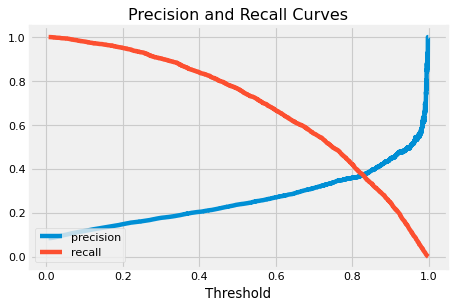

In [196]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

lm = LogisticRegression(C=30, class_weight='{0: 1, 1: 20}').fit(X_tr_us_scaled, y_tr_us)
    
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lm.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

In [197]:
def make_confusion_matrix(m, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)    
    m.fit(X_tr_us_scaled, y_tr_us)
    y_predict = (m.predict_proba(X_val_scaled)[:, 1] >= threshold)
    heart_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(heart_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no', 'yes'],
           yticklabels=['no', 'yes'])
    plt.xlabel('prediction')
    plt.ylabel('actual');

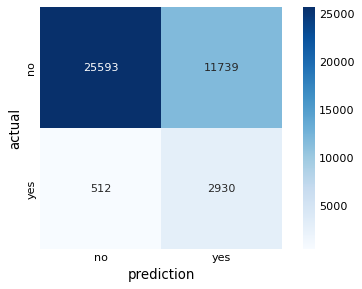

In [296]:
make_confusion_matrix(LogisticRegression(C=30, class_weight='{0: 1, 1: 20}'), 0.38)

Text(0, 0.5, 'True Positive Rate')

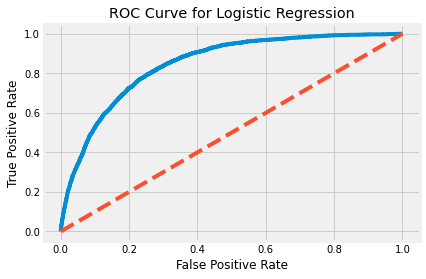

In [224]:
from sklearn.metrics import roc_curve

lm = LogisticRegression(C=30, class_weight='{0: 1, 1: 20}').fit(X_tr_us_scaled, y_tr_us)

fpr, tpr, _ = roc_curve(y_val, lm.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#exploring optimal parameters

In [309]:
#validation function

def validation(m, threshold=0.5):
    m.fit(X_tr_us_scaled, y_tr_us)
    y_pred = (m.predict_proba(X_val_scaled)[:, 1] >= threshold)
    y_t_pred = (m.predict_proba(X_test_scaled)[:, 1] >= threshold)
    
    print('_'*50, '\n')
    print(f'model: {str(m)}')
    print(f' accuracy on training set: {m.score(X_tr_us_scaled, y_tr_us)}')
    print(f' accuracy on validation set: {m.score(X_val_scaled, y_val)}')
    print(f' accuracy on test set: {m.score(X_test_scaled, y_test)}')
    print(f' precission: {precision_score(y_val,y_pred)}')
    print(f' precission on test set: {precision_score(y_test,y_t_pred)}')
    print(f' recall: {recall_score(y_val,y_pred)}')
    print(f' recall on test set: {recall_score(y_test,y_t_pred)}')
    print(f' F1: {f1_score(y_val,y_pred)}')
    print(f' F1 on test set: {f1_score(y_test,y_t_pred)}')
    print('_'*50, '\n')

In [310]:
#class_weight is adressing class imbalance and improving score
validation(LogisticRegression(C=30, class_weight='{0: 1, 1: 20}'), threshold=0.38)

#interesting that in that case accuracy is higher on validation set

__________________________________________________ 

model: LogisticRegression(C=30, class_weight='{0: 1, 1: 20}')
 accuracy on training set: 0.7741810002198657
 accuracy on validation set: 0.7719134742728209
 accuracy on test set: 0.7666875130289764
 precission: 0.19974095030336084
 precission on test set: 0.2038952085487763
 recall: 0.8512492736780941
 recall on test set: 0.840596873519659
 F1: 0.3235602672409033
 F1 on test set: 0.32818568522285935
__________________________________________________ 



# knn

In [225]:
#exploring optimal parameters

from sklearn.model_selection import RandomizedSearchCV

parameters = [{'n_neighbors':[1,3,5,7,9,11, 13,15]}, 
              {'weights':['uniform', 'distance']}
             ]

knn = KNeighborsClassifier()
knn.fit(X_tr_us_scaled, y_tr_us)

grid_search = RandomizedSearchCV(estimator = knn,  
                           param_distributions = parameters,
                           scoring = 'recall'
                                )


tuned_lr = grid_search.fit(X_tr_us_scaled, y_tr_us)

In [226]:
grid_search.best_score_

0.5712110556121359

In [227]:
grid_search.best_params_

{'n_neighbors': 15}

In [35]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=15)

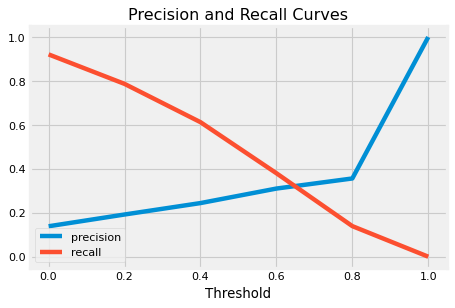

In [229]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

In [230]:
def make_confusion_matrix(m, threshold=0.5): 
    m.fit(X_tr_us_scaled, y_tr_us)
    y_pred = (m.predict_proba(X_val_scaled)[:, 1] >= threshold)
    heart_confusion = confusion_matrix(y_val, y_pred)
    plt.figure(dpi=80)
    sns.heatmap(heart_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no', 'yes'],
           yticklabels=['no', 'yes'])
    plt.xlabel('prediction')
    plt.ylabel('actual');

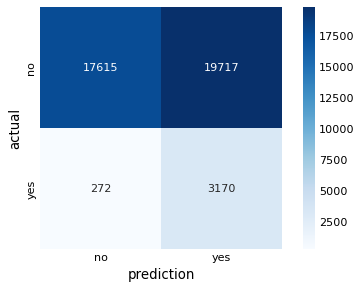

In [231]:
make_confusion_matrix(knn, 0.05)

Text(0, 0.5, 'True Positive Rate')

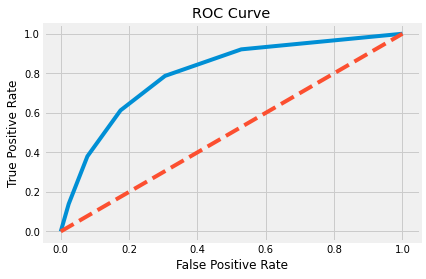

In [37]:
fpr, tpr, _ = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#exploring optimal parameters

In [311]:
#validation function

def validation(m, threshold=0.5):
    m.fit(X_tr_us_scaled, y_tr_us)
    y_pred = (m.predict_proba(X_val_scaled)[:, 1] >= threshold)
    y_t_pred = (m.predict_proba(X_test_scaled)[:, 1] >= threshold)
    
    print('_'*50, '\n')
    print(f'model: {str(m)}')
    print(f' accuracy on training set: {m.score(X_tr_us_scaled, y_tr_us)}')
    print(f' accuracy on validation set: {m.score(X_val_scaled, y_val)}')
    print(f' accuracy on test set: {m.score(X_test_scaled, y_test)}')
    print(f' precission: {precision_score(y_val,y_pred)}')
    print(f' precission on test set: {precision_score(y_test,y_t_pred)}')
    print(f' recall: {recall_score(y_val,y_pred)}')
    print(f' recall on test set: {recall_score(y_test,y_t_pred)}')
    print(f' F1: {f1_score(y_val,y_pred)}')
    print(f' F1 on test set: {f1_score(y_test,y_t_pred)}')
    print('_'*50, '\n')

In [315]:
validation(KNeighborsClassifier(n_neighbors=15), threshold=0.265)

__________________________________________________ 

model: KNeighborsClassifier(n_neighbors=15)
 accuracy on training set: 0.7896223383564193
 accuracy on validation set: 0.8238828665325943
 accuracy on test set: 0.8178027934125495
 precission: 0.17870430520285832
 precission on test set: 0.18245438640339914
 recall: 0.8791400348634515
 recall on test set: 0.8645191852202747
 F1: 0.29703067484662576
 F1 on test set: 0.3013167127584926
__________________________________________________ 



# random forest

In [45]:
#exploring optimal parameters - I have run it many times, to fine tune

from sklearn.model_selection import RandomizedSearchCV

parameters = {'class_weight':['balanced'],
              'bootstrap': [False],
              'max_depth': [70, 80],
              'max_features': [3, 4],
              'min_samples_leaf': [6, 7],
              'min_samples_split': [3, 4],
              'n_estimators': [900, 1000, 1100]}
             

grid_search = RandomizedSearchCV(estimator = randomforest,  
                           param_distributions = parameters,
                           n_iter = 10, #number of parrameter settings = 10
                           scoring = 'recall',
                           n_jobs = -1, #all procesors
                           cv = 3 #cross validation folds
                                )


tuned_lr = grid_search.fit(X_tr_us_scaled, y_tr_us)

In [46]:
grid_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 3,
 'min_samples_leaf': 7,
 'max_features': 4,
 'max_depth': 80,
 'class_weight': 'balanced',
 'bootstrap': False}

In [40]:
randomforest = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=80,
                       max_features=4, min_samples_leaf=7, min_samples_split=3,
                       n_estimators=1100)
randomforest.fit(X_tr_us_scaled, y_tr_us)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=80,
                       max_features=4, min_samples_leaf=7, min_samples_split=3,
                       n_estimators=1100)

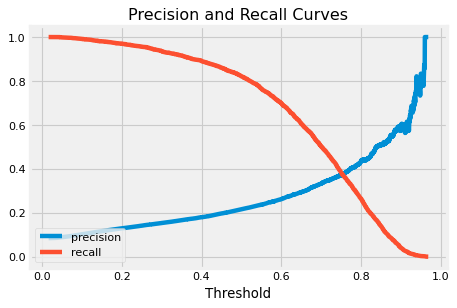

In [41]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, randomforest.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

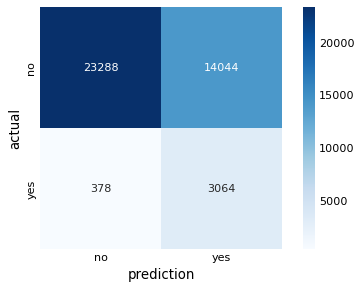

In [42]:
make_confusion_matrix(randomforest, 0.4)

Text(0, 0.5, 'True Positive Rate')

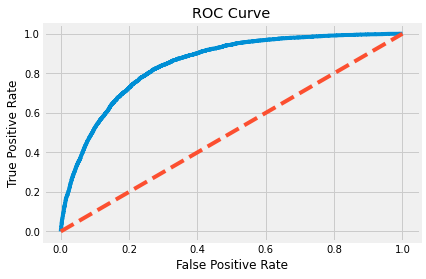

In [43]:
fpr, tpr, _ = roc_curve(y_val, randomforest.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#exploring optimal parameters

In [316]:
#validation function

def validation(m, threshold=0.5):
    m.fit(X_tr_us_scaled, y_tr_us)
    y_pred = (m.predict_proba(X_val_scaled)[:, 1] >= threshold)
    y_t_pred = (m.predict_proba(X_test_scaled)[:, 1] >= threshold)
    
    print('_'*50, '\n')
    print(f'model: {str(m)}')
    print(f' accuracy on training set: {m.score(X_tr_us_scaled, y_tr_us)}')
    print(f' accuracy on validation set: {m.score(X_val_scaled, y_val)}')
    print(f' accuracy on test set: {m.score(X_test_scaled, y_test)}')
    print(f' precission: {precision_score(y_val,y_pred)}')
    print(f' precission on test set: {precision_score(y_test,y_t_pred)}')
    print(f' recall: {recall_score(y_val,y_pred)}')
    print(f' recall on test set: {recall_score(y_test,y_t_pred)}')
    print(f' F1: {f1_score(y_val,y_pred)}')
    print(f' F1 on test set: {f1_score(y_test,y_t_pred)}')
    print('_'*50, '\n')

In [317]:
validation(RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=80,
                       max_features=4, min_samples_leaf=7, min_samples_split=3,
                       n_estimators=1100), threshold=0.45)

__________________________________________________ 

model: RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=80,
                       max_features=4, min_samples_leaf=7, min_samples_split=3,
                       n_estimators=1100)
 accuracy on training set: 0.7869501243086915
 accuracy on validation set: 0.7331387648992005
 accuracy on test set: 0.7275380446112153
 precission: 0.1972974772016242
 precission on test set: 0.19906297060628034
 recall: 0.8611272515979081
 recall on test set: 0.8453339649455235
 F1: 0.32103980503655566
 F1 on test set: 0.3222427881359758
__________________________________________________ 



# XGBoost

In [333]:
#exploring optimal parameters - I have run it many, many times, to fine tune

from sklearn.model_selection import RandomizedSearchCV

parameters = {'eval_metric':['rmse'],
              'use_label_encoder':['False'],
              'n_estimators':[int(x) for x in np.linspace(start = 700, stop = 1000, num = 5)],
              'learning_rate':[round(x,2) for x in np.linspace(start = .0, stop = .2, num = 20)],
              'min_child_weight': [1,2,3],
              'gamma': [1.1,1.3,1.5],
              'subsample': [.5,.6,.7],
              'scale_pos_weight':[6,8,10],
              'max_deph': range(6,8,1)
              }
             

boosted_classifier.fit(X_tr_us_scaled, y_tr_us)

grid_search = RandomizedSearchCV(estimator = boosted_classifier,  
                           param_distributions = parameters,
                           n_iter = 10, #number of parrameter settings = 10
                           scoring = 'recall',
                           n_jobs = -1, #all procesors
                           cv = 3 #cross validation folds
                                )


tuned_lr = grid_search.fit(X_tr_us_scaled, y_tr_us)
#removed max_deph according to advice

/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecate

/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/krystiankrystkowiak/opt/anaconda3

[01:23:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "max_deph" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [111]:
grid_search.best_params_

{'use_label_encoder': 'False',
 'subsample': 0.5,
 'scale_pos_weight': 10,
 'n_estimators': 850,
 'min_child_weight': 2,
 'max_deph': 6,
 'learning_rate': 0.04,
 'gamma': 1.3,
 'eval_metric': 'rmse'}

In [112]:
grid_search.best_estimator_


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='rmse', gamma=1.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.04, max_delta_step=0,
              max_deph=6, max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=850, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.5,
              tree_method='exact', use_label_encoder='False',
              validate_parameters=1, ...)

In [301]:
boosted_classifier = xgb.XGBClassifier(eval_metric='rmse', use_label_encoder=False, subsample=0.5, scale_pos_weight=10, n_estimators=850, min_child_weight=2, learning_rate=0.04, gamma=1.3)
boosted_classifier.fit(X_train_scaled, y_train)

#validation(boosted_classifier, threshold=0.5)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='rmse', gamma=1.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.04, max_delta_step=0,
              max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=850, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.5,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

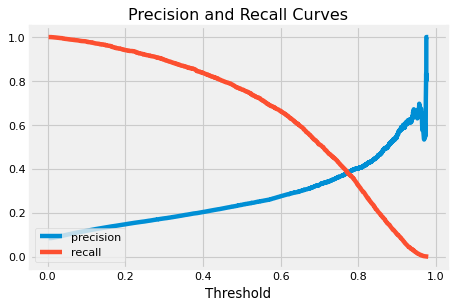

In [302]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, boosted_classifier.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

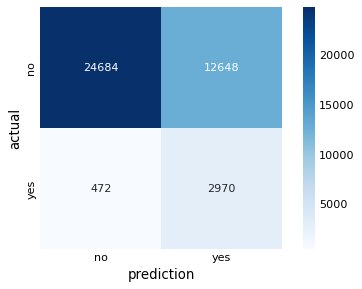

In [320]:
make_confusion_matrix(boosted_classifier, 0.75)

Text(0, 0.5, 'True Positive Rate')

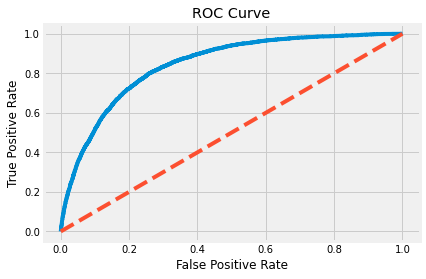

In [321]:
fpr, tpr, _ = roc_curve(y_val, boosted_classifier.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [305]:
#validation function

def validation(m, threshold=0.5):
    m.fit(X_tr_us_scaled, y_tr_us)
    y_pred = (m.predict_proba(X_val_scaled)[:, 1] >= threshold)
    y_t_pred = (m.predict_proba(X_test_scaled)[:, 1] >= threshold)
    
    print('_'*50, '\n')
    print(f'model: {str(m)}')
    print(f' accuracy on training set: {m.score(X_tr_us_scaled, y_tr_us)}')
    print(f' accuracy on validation set: {m.score(X_val_scaled, y_val)}')
    print(f' accuracy on test set: {m.score(X_test_scaled, y_test)}')
    print(f' precission: {precision_score(y_val,y_pred)}')
    print(f' precission on test set: {precision_score(y_test,y_t_pred)}')
    print(f' recall: {recall_score(y_val,y_pred)}')
    print(f' recall on test set: {recall_score(y_test,y_t_pred)}')
    print(f' F1: {f1_score(y_val,y_pred)}')
    print(f' F1 on test set: {f1_score(y_test,y_t_pred)}')
    print('_'*50, '\n')

In [306]:
validation(boosted_classifier, threshold=0.75)

__________________________________________________ 

model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='rmse', gamma=1.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.04, max_delta_step=0,
              max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=850, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.5,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
 accuracy on training set: 0.6510392883116004
 accuracy on validation set: 0.49931328787953105
 accuracy on test set: 0.8552637064832187
 precission: 0.1901651940069151
 precission on test set: 0.19358682699599178
 recall: 0.862870424171993
 rec

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

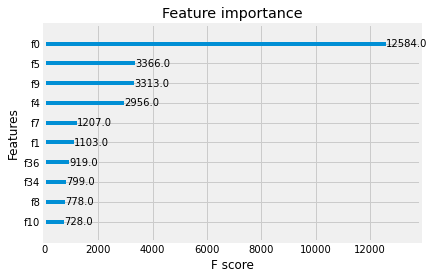

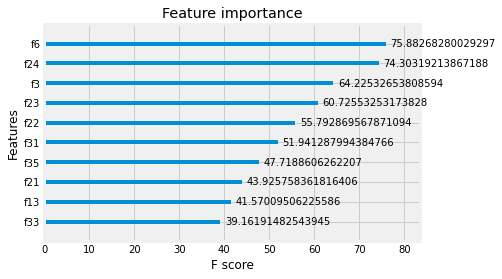

In [322]:
xgb.plot_importance(boosted_classifier, max_num_features=10)
xgb.plot_importance(boosted_classifier, importance_type='gain', max_num_features=10)

In [332]:
X_test.columns[13]

'AgeCategory_25-29'

# Naive Bayes

In [132]:
nb = BernoulliNB() 
nb.fit(X_tr_us_scaled, y_tr_us)

BernoulliNB()

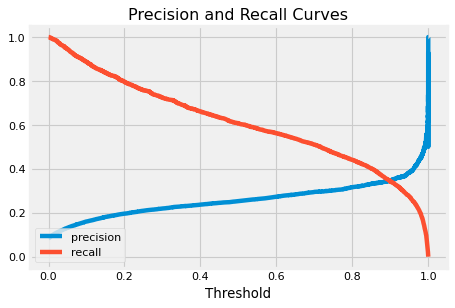

In [135]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, nb.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

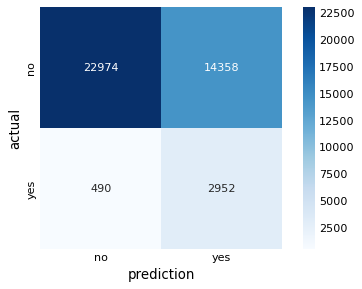

In [279]:
make_confusion_matrix(nb, 0.125)

Text(0, 0.5, 'True Positive Rate')

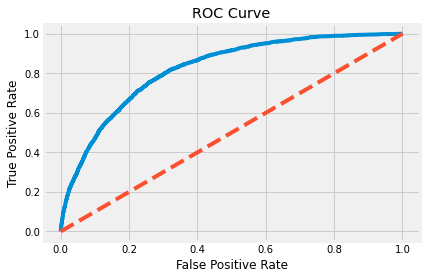

In [280]:
fpr, tpr, _ = roc_curve(y_val, nb.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [318]:
#validation function

def validation(m, threshold=0.5):
    m.fit(X_tr_us_scaled, y_tr_us)
    y_pred = (m.predict_proba(X_val_scaled)[:, 1] >= threshold)
    y_t_pred = (m.predict_proba(X_test_scaled)[:, 1] >= threshold)
    
    print('_'*50, '\n')
    print(f'model: {str(m)}')
    print(f' accuracy on training set: {m.score(X_tr_us_scaled, y_tr_us)}')
    print(f' accuracy on validation set: {m.score(X_val_scaled, y_val)}')
    print(f' accuracy on test set: {m.score(X_test_scaled, y_test)}')
    print(f' precission: {precision_score(y_val,y_pred)}')
    print(f' precission on test set: {precision_score(y_test,y_t_pred)}')
    print(f' recall: {recall_score(y_val,y_pred)}')
    print(f' recall on test set: {recall_score(y_test,y_t_pred)}')
    print(f' F1: {f1_score(y_val,y_pred)}')
    print(f' F1 on test set: {f1_score(y_test,y_t_pred)}')
    print('_'*50, '\n')

In [319]:
validation(nb, threshold=0.125)

__________________________________________________ 

model: BernoulliNB()
 accuracy on training set: 0.7591624807617501
 accuracy on validation set: 0.8153725413253544
 accuracy on test set: 0.8124244319366271
 precission: 0.17053726169844022
 precission on test set: 0.17598212984994901
 recall: 0.8576409064497386
 recall on test set: 0.8583609663666508
 F1: 0.284502698535081
 F1 on test set: 0.2920814023775942
__________________________________________________ 

